In [1]:
import numpy as np
import keras,gc, os, time, sys, nltk
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.special import expit
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
nltk.download('reuters')
nltk.download('wordnet')
%matplotlib inline

from base_networks import *
from utils import check_availability, load_imgs_mask
from utils import get_topK_labels,set_newlabel_list, enmask_data

np.random.seed(20)

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmena/.local/lib/python3.5/site-package

[nltk_data] Downloading package reuters to /home/fmena/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fmena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def plot_cells_distribution(Nb,train_hash,test_hash=[]):
    print("Cantidad de memorias en tabla hash: ",2**Nb)

    valores_unicos, count_hash =  hash_analysis(train_hash)
    print("Entrenamiento----")
    print("Cantidad de datos a llenar la tabla hash: ",train_hash.shape[0])
    plt.figure(figsize=(14,4))
    plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
    plt.title("Cantidad de datos por celda/memoria en tabla hash")
    plt.show()
    print("Cantidad de memorias ocupadas: ",len(valores_unicos))
    if len(test_hash) != 0:
        valores_unicos, count_hash =  hash_analysis(test_hash)
        print("Pruebas-----")
        print("Cantidad de datos a llenar la tabla hash: ",test_hash.shape[0])
        plt.figure(figsize=(14,4))
        plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
        plt.title("Cantidad de datos por celda/memoria en tabla hash")
        plt.show()
        print("Cantidad de memorias ocupadas: ",len(valores_unicos))
        
def hash_analysis(hash_data):
    hash_string = []
    for valor in hash_data:
        hash_string.append(str(valor)[1:-1].replace(' ',''))
    valores_unicos = set(hash_string)
    count_hash = {valor: hash_string.count(valor) for valor in valores_unicos}
    return valores_unicos, count_hash


def measure_metrics(hash_data):
    valores_unicos, count_hash =  hash_analysis(hash_data)
    dis_cell = np.asarray(list(count_hash.values()))
    
    N_data, B_data = hash_data.shape
    
    norm_dis_cell = dis_cell/N_data #np.sum(dis_cell)
    
    N_hash = 2.**B_data
    N_hash_used = len(dis_cell)
    N_hash_empty = N_hash-N_hash_used

    top10_dis = sorted(dis_cell)[::-1][:10]
    mean_N_xcell = np.mean(dis_cell)
    std_N_xcell = np.std(dis_cell)
    
    #calcular varianza y cosas..
    
    ref_dis = np.tile(1./len(norm_dis_cell), len(norm_dis_cell))
    
    H_cells = -np.sum(norm_dis_cell* np.log(norm_dis_cell+ 1e-7))
    H_balanced = -np.sum(ref_dis* np.log(ref_dis+ 1e-7))
    
    G_indx = 1 - np.sum(norm_dis_cell**2)
    G_indx_balanced = 1 - np.sum(ref_dis**2)    
    return N_data, N_hash, N_hash_used, N_hash_empty, top10_dis,mean_N_xcell,   std_N_xcell, H_cells/H_balanced,G_indx/G_indx_balanced

def compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B):
    N_data = []
    Np_hash_empty = []
    top10_dis = []
    mean_N_xcell = []
    std_N_xcell = []
    H_N = []
    Gini_N = []
    
    n, a, b, c, d,e , f, g, h = measure_metrics(train_hash_)
    N_data.append(n)
    Np_hash_empty.append(c/a)
    top10_dis.append(d)
    mean_N_xcell.append(e)
    std_N_xcell.append(f)
    H_N.append(g)   
    Gini_N.append(h)
    
    n, a, b, c, d,e , f, g, h = measure_metrics(train_hash_B)
    N_data.append(n)
    Np_hash_empty.append(c/a)
    top10_dis.append(d)
    mean_N_xcell.append(e)
    std_N_xcell.append(f)
    H_N.append(g)  
    Gini_N.append(h)
    
    n, a, b, c, d,e , f, g, h = measure_metrics(test_hash_)
    N_data.append(n)
    Np_hash_empty.append(c/a)
    top10_dis.append(d)
    mean_N_xcell.append(e)
    std_N_xcell.append(f)
    H_N.append(g)  
    Gini_N.append(h)
    
    n, a, b, c, d,e , f, g, h = measure_metrics(test_hash_B)
    N_data.append(n)
    Np_hash_empty.append(c/a)
    top10_dis.append(d)
    mean_N_xcell.append(e)
    std_N_xcell.append(f)
    H_N.append(g)  
    Gini_N.append(h)
    
    df = pd.DataFrame({"#data":N_data, "#empty cells(%)":Np_hash_empty, 
                       "mean #data x cell":mean_N_xcell, "std #data x cell":std_N_xcell,
                       "H cells dis":H_N, "Gini cells dis": Gini_N,
                      "top10":top10_dis})
    df["Type"] = ["VDSH train","B-VAE train", "VDSH test","B-VAE test"]

    return df

#cells 	#data 	#empty cells 	#empty cells(%) 	#used cells/#data 	mean #data x cell 	top10 	Type

from utils import calculate_hash, compare_cells_plot

### Choose load data

In [55]:
name_dat = "20News"

from sklearn.datasets import fetch_20newsgroups
newsgroups_t = fetch_20newsgroups(subset='train')
labels = newsgroups_t.target_names

from utils import Load_Dataset

filename = 'Data/ng20.tfidf.mat'
data = Load_Dataset(filename)

X_train_input = data["train"]
X_train = X_train_input 
X_val_input = data["cv"]
X_val = X_val_input 
X_test_input = data["test"]
X_test = X_test_input
labels_train = np.asarray([labels[value.argmax(axis=-1)] for value in data["gnd_train"]])
labels_val = np.asarray([labels[value.argmax(axis=-1)] for value in data["gnd_cv"]])
labels_test = np.asarray([labels[value.argmax(axis=-1)] for value in data["gnd_test"]])


print("Cantidad de datos Entrenamiento: ",len(labels_train))
print("Cantidad de datos Validación: ",len(labels_val))
print("Cantidad de datos Pruebas: ",len(labels_test))

Cantidad de datos Entrenamiento:  11016
Cantidad de datos Validación:  3667
Cantidad de datos Pruebas:  3668


In [62]:
name_dat = "Reuters"
labels = ['a','b','c','d','e','f','e','g','h','i','j','k','l','m','n','o','p','q','r','s']

filename = 'Data/reuters.tfidf.mat'
data = Load_Dataset(filename)

X_train_input = data["train"]
X_train = X_train_input 
X_val_input = data["cv"]
X_val = X_val_input 
X_test_input = data["test"]
X_test = X_test_input

labels = np.asarray(labels)
labels_train = np.asarray([labels[value.astype(bool)] for value in data["gnd_train"]])
labels_val = np.asarray([labels[value.astype(bool)] for value in data["gnd_cv"]])
labels_test = np.asarray([labels[value.astype(bool)] for value in data["gnd_test"]])

print("Cantidad de datos Entrenamiento: ",len(labels_train))
print("Cantidad de datos Validación: ",len(labels_val))
print("Cantidad de datos Pruebas: ",len(labels_test))

Cantidad de datos Entrenamiento:  7752
Cantidad de datos Validación:  964
Cantidad de datos Pruebas:  967


In [67]:
name_dat = "TMC"

labels = ['a','b','c','d','e','f','e','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u']

filename = 'Data/tmc.tfidf.mat'
data = Load_Dataset(filename)

X_train_input = data["train"]
X_train = X_train_input 
X_val_input = data["cv"]
X_val = X_val_input 
X_test_input = data["test"]
X_test = X_test_input

labels = np.asarray(labels)
labels_train = np.asarray([labels[value.astype(bool)] for value in data["gnd_train"]])
labels_val = np.asarray([labels[value.astype(bool)] for value in data["gnd_cv"]])
labels_test = np.asarray([labels[value.astype(bool)] for value in data["gnd_test"]])

print("Cantidad de datos Entrenamiento: ",len(labels_train))
print("Cantidad de datos Validación: ",len(labels_val))
print("Cantidad de datos Pruebas: ",len(labels_test))

Cantidad de datos Entrenamiento:  21286
Cantidad de datos Validación:  3498
Cantidad de datos Pruebas:  3498


Datos de entrenamiento:  10060
Datos de pruebas:  2280
Cantidad de datos Entrenamiento:  9054
Cantidad de datos Validación:  1006
Cantidad de datos Pruebas:  2280


/home/fmena/.local/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 1.63 s, sys: 5.74 ms, total: 1.63 s
Wall time: 1.62 s


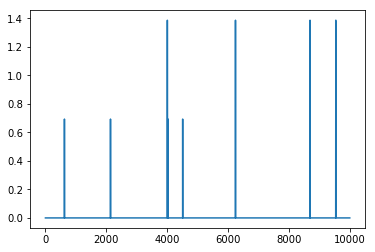

In [72]:
name_dat = "Snippets"

def read_file(archivo,symb=' '):
    with open(archivo,'r') as f:
        lineas = f.readlines()
        tokens_f = [linea.strip().split(symb) for linea in lineas]
        labels = [tokens[-1] for tokens in tokens_f]
        tokens = [' '.join(tokens[:-1]) for tokens in tokens_f]
    return labels,tokens
labels_t,texts_t = read_file("Data/data-web-snippets/train.txt")
labels_test,texts_test = read_file("Data/data-web-snippets/test.txt")
print("Datos de entrenamiento: ",len(texts_t))
print("Datos de pruebas: ",len(texts_test))

labels = list(set(labels_t))

from sklearn.model_selection import train_test_split
labels_t = np.asarray(labels_t)
labels_test = np.asarray(labels_test)
texts_train,texts_val,labels_train,labels_val  = train_test_split(texts_t,labels_t,random_state=20,test_size=0.1)

print("Cantidad de datos Entrenamiento: ",len(texts_train))
print("Cantidad de datos Validación: ",len(texts_val))
print("Cantidad de datos Pruebas: ",len(texts_test))


from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
tokenizer = TfidfVectorizer().build_tokenizer()
stemmer = SnowballStemmer("english") 
lemmatizer = WordNetLemmatizer()

"""Extract features from raw input"""
def preProcess(s): #String processor
    return s.lower().strip().strip('-').strip('_')
def number_normalize(doc):
    results = []
    for token in tokenizer(doc):
        token_pro = preProcess(token)
        if len(token_pro) != 0 and not token_pro[0].isdigit():
            results.append(token_pro)
    return results
def stemmed_words(doc):
    results = []
    for token in tokenizer(doc):
        pre_pro = preProcess(token)
        #token_pro = stemmer.stem(pre_pro) #aumenta x10 el tiempo de procesamiento
        token_pro = lemmatizer.lemmatize(pre_pro) #so can explain/interpretae -- aumenta x5 el tiempo de proce
        if len(token_pro) > 2 and not token_pro[0].isdigit(): #elimina palabra largo menor a 2
            results.append(token_pro)
    return results

def get_transform_representation(mode, analizer,min_count,max_feat):
    smooth_idf_b = False
    use_idf_b = False
    binary_b = False

    if mode == 'binary':
        binary_b = True
    elif mode == 'tf':     
        pass #default is tf
    elif mode == 'tf-idf':
        use_idf_b = True
        smooth_idf_b = True #inventa 1 conteo imaginario (como priors)--laplace smoothing
    return TfidfVectorizer(stop_words='english',tokenizer=analizer,min_df=min_count, max_df=0.8, max_features=max_feat
                                ,binary=binary_b, use_idf=use_idf_b, smooth_idf=smooth_idf_b,norm=None
                                  ,ngram_range=(1, 3)) 

min_count = 1 #default = 1
max_feat = 10000 #Best: 10000 -- Hinton (2000)
vectorizer = get_transform_representation("tf", stemmed_words,min_count,max_feat)

%time vectorizer.fit(texts_train)
vectors_train = vectorizer.transform(texts_train)
vectors_val = vectorizer.transform(texts_val)
vectors_test = vectorizer.transform(texts_test)

token2idx = vectorizer.vocabulary_
idx2token = {idx:token for token,idx in token2idx.items()}



#todense --get representation
X_train = np.asarray(vectors_train.todense())
X_val = np.asarray(vectors_val.todense())
X_test = np.asarray(vectors_test.todense())
del vectors_train,vectors_val,vectors_test#,vectors_train2,vectors_val2,vectors_test2
gc.collect()


##representacion soft para TF ---mucho mejor!
X_train_input = np.log(X_train+1) 
X_val_input = np.log(X_val+1) 
X_test_input = np.log(X_test+1) 
plt.plot(X_train_input[0])
plt.show()

#### Para texto

In [73]:
#outputs as probabolities -- normalized over datasets..
X_train = X_train/X_train.sum(axis=-1,keepdims=True) 
X_val = X_val/X_val.sum(axis=-1,keepdims=True)
X_test = X_test/X_test.sum(axis=-1,keepdims=True)
print("Output target normalizado en dataset ",name_dat)

X_train[np.isnan(X_train)] = 0
X_val[np.isnan(X_val)] = 0
X_test[np.isnan(X_test)] = 0

X_total_input = np.concatenate((X_train_input,X_val_input),axis=0)
X_total = np.concatenate((X_train,X_val),axis=0)
labels_total = np.concatenate((labels_train,labels_val),axis=0)
del X_train_input, X_train, X_val, X_val_input
gc.collect()

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


Output target normalizado en dataset  Snippets


4935

In [50]:
name_dat = "MNIST"

(_, aux_t), (_, aux_test) = keras.datasets.mnist.load_data()
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
labels_t = np.asarray([labels[value] for value in aux_t])
labels_test = np.asarray([labels[value] for value in aux_test])
labels_t = np.concatenate((labels_t,labels_test),axis=0)

X_t = np.load("../AUX/VGG_128/mnist_VGG_avg.npy")
X_t.shape

(70000, 512)

In [45]:
name_dat = "CIFAR-10"

(_, aux_t), (_, aux_test) = keras.datasets.cifar10.load_data()

labels = ["airplane", "automobile","bird", "cat","deer","dog","frog","horse","ship","truck"]
labels_t = np.asarray([labels[value[0]] for value in aux_t])
labels_test = np.asarray([labels[value[0]] for value in aux_test])
labels_t = np.concatenate((labels_t,labels_test),axis=0)

X_t = np.load("../AUX/VGG_224/cifar10_VGG_avg.npy") #mejora
X_t.shape

(60000, 512)

In [35]:
name_dat = "Nus-Wide"

folder = "../Dataset_NUSWIDE/"
mask_av = np.loadtxt("./Data/"+name_dat+"_mask_avail.txt").astype(bool)

labels = pd.read_csv(folder+'Concepts81.txt',header=None).values.reshape(1,-1)[0]
print("Cantidad de labels: ",len(labels) )

labels_t = [[] for _ in range(269648)]
for concept in labels:
    aux = pd.read_csv(folder+"Groundtruth/AllLabels/Labels_"+concept+".txt",header=None)
    indexs_true = aux.loc[(aux==1).values[:,0]].index
    
    for value in indexs_true:
        labels_t[value].append(concept)
        
labels_t = enmask_data(labels_t, mask_av)
N_total = len(labels_t)
print("Cantidad de objetos: ",N_total )

new_labels = get_topK_labels(labels_t, labels, K=21)

labels_t = set_newlabel_list(new_labels, labels_t)
labels = new_labels
# y si quedan datos sin clase?
mask_used_t = np.asarray(list(map(len,labels_t))) != 0

labels_t = enmask_data(labels_t, mask_used_t)
print("Cantidad de objetos: ", len(labels_t) )

X_t = np.load("../AUX/VGG_224/nuswide_VGG_avg.npy")
X_t.shape

Cantidad de labels:  81
Cantidad de objetos:  169500
category with most data (sky) has = 61066, the top-K category (mountain) has = 4232
Cantidad de objetos:  158383


(158383, 512)

#### Para imagenes

In [51]:
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100)

## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))


from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_t)

X_total = std.transform(X_t)
X_test = std.transform(X_test)

X_total_input = X_total
X_test_input = X_test

Cantidad de datos Entrenamiento:  69000
Cantidad de datos Pruebas:  1000


## load model

In [74]:
if "mnist" in name_dat.lower() or "cifar" in name_dat.lower() or "nus-wide" in name_dat.lower():
    type_n = "VGG"
else:
    type_n = "TFIDF"

print(type_n)

BITS_S = 32

##load model
encoder_Tvae = keras.models.load_model("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_E_"+type_n+"_B?.h5")
encoder_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_"+type_n+"_B?.h5")
encoder_Bvae.summary()

TFIDF
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
sequential_28 (Sequential)   (None, 500)               5255000   
_________________________________________________________________
logits-b (Dense)             (None, 32)                16032     
Total params: 5,271,032
Trainable params: 5,269,032
Non-trainable params: 2,000
_________________________________________________________________


/home/fmena/.local/lib/python3.5/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [75]:
train_hash_ = calculate_hash(encoder_Tvae.predict(X_total_input), from_probas=False)
test_hash_ = calculate_hash(encoder_Tvae.predict(X_test_input),  from_probas=False)

train_hash_B = calculate_hash(encoder_Bvae.predict(X_total_input), from_probas=True)
test_hash_B = calculate_hash(encoder_Bvae.predict(X_test_input),  from_probas=True)

In [40]:
print("Numero de Bits= ",BITS_S)

Numero de Bits=  8


In [8]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

20News


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,14683,0.078125,0.987452,0.839131,62.216102,106.836759,"[874, 696, 394, 383, 372, 361, 359, 347, 341, ...",VDSH train
1,14683,0.148438,0.980620,0.800122,67.353211,138.123097,"[1151, 866, 656, 578, 484, 483, 465, 462, 334,...",B-VAE train
2,3668,0.269531,0.984713,0.836358,19.614973,33.075047,"[260, 194, 135, 109, 98, 96, 88, 88, 87, 84]",VDSH test
3,3668,0.316406,0.976047,0.797487,20.960000,42.790701,"[322, 253, 185, 174, 172, 141, 131, 104, 94, 91]",B-VAE test


In [14]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

Reuters


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,8716,0.359375,0.973429,0.791104,53.146341,110.604947,"[865, 815, 376, 338, 335, 267, 247, 245, 233, ...",VDSH train
1,8716,0.757812,0.952928,0.742352,140.580645,238.216325,"[1031, 951, 714, 661, 647, 500, 483, 480, 426,...",B-VAE train
2,967,0.652344,0.973432,0.843104,10.865169,16.613377,"[109, 82, 57, 40, 37, 37, 33, 32, 28, 22]",VDSH test
3,967,0.843750,0.952819,0.795213,24.175000,32.793206,"[118, 114, 102, 82, 79, 64, 59, 48, 40, 31]",B-VAE test


In [19]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

TMC


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,24784,0.207031,0.987905,0.841057,122.088670,190.836974,"[1214, 1137, 1080, 680, 644, 611, 590, 570, 51...",VDSH train
1,24784,0.640625,0.973804,0.786794,269.391304,415.931222,"[1796, 1602, 1337, 1266, 1184, 1182, 1157, 110...",B-VAE train
2,3498,0.410156,0.988030,0.867489,23.165563,31.040762,"[186, 172, 151, 96, 93, 92, 88, 87, 82, 76]",VDSH test
3,3498,0.746094,0.975059,0.826833,53.815385,67.991604,"[252, 209, 205, 201, 199, 186, 178, 165, 160, ...",B-VAE test


In [24]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

Snippets


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,10060,0.050781,0.992044,0.874373,41.399177,57.445780,"[475, 299, 273, 205, 204, 201, 179, 176, 161, ...",VDSH train
1,10060,0.042969,0.989268,0.859134,41.061224,66.445500,"[643, 281, 281, 272, 246, 211, 211, 206, 196, ...",B-VAE train
2,2280,0.453125,0.980866,0.845335,16.285714,26.559175,"[209, 122, 113, 99, 99, 57, 54, 54, 53, 53]",VDSH test
3,2280,0.273438,0.987749,0.866294,12.258065,18.454188,"[131, 104, 104, 76, 67, 61, 52, 52, 49, 48]",B-VAE test


In [29]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

MNIST


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,69000,0.000000,0.992141,0.885454,269.531250,381.551631,"[2520, 2477, 2011, 1986, 1780, 1575, 1564, 135...",VDSH train
1,69000,0.046875,0.967473,0.743243,282.786885,795.033124,"[8063, 6959, 2396, 2303, 2267, 2132, 2125, 205...",B-VAE train
2,1000,0.222656,0.992204,0.904266,5.025126,6.243338,"[41, 35, 31, 31, 28, 24, 22, 20, 18, 18]",VDSH test
3,1000,0.515625,0.968277,0.814486,8.064516,15.930161,"[125, 101, 39, 37, 37, 34, 31, 29, 28, 26]",B-VAE test


In [34]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

CIFAR-10


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,58100,0.000000,0.996275,0.937852,226.953125,221.201685,"[1444, 1421, 1316, 1210, 1102, 1022, 775, 773,...",VDSH train
1,58100,0.003906,0.993046,0.898018,227.843137,302.816062,"[2195, 1818, 1681, 1403, 1240, 1228, 1179, 111...",B-VAE train
2,1900,0.050781,0.992874,0.909589,7.818930,10.268020,"[90, 74, 65, 49, 35, 35, 29, 25, 25, 24]",VDSH test
3,1900,0.109375,0.990980,0.885086,8.333333,11.924593,"[76, 74, 63, 54, 52, 49, 47, 41, 39, 39]",B-VAE test


In [39]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

Nus-Wide


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,156283,0.000000,0.993023,0.907571,610.480469,814.272139,"[7455, 5927, 4787, 4363, 2891, 2667, 2356, 221...",VDSH train
1,156283,0.000000,0.955354,0.748948,610.480469,2059.828910,"[28525, 9328, 7761, 6489, 6484, 4344, 3823, 37...",B-VAE train
2,2100,0.140625,0.979651,0.844905,9.545455,20.150631,"[220, 125, 107, 88, 56, 49, 41, 36, 33, 33]",VDSH test
3,2100,0.300781,0.895384,0.663068,11.731844,50.626308,"[622, 231, 109, 94, 68, 43, 43, 41, 38, 36]",B-VAE test


In [43]:
print("Numero de Bits= ",BITS_S)

Numero de Bits=  32


In [59]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

20News


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,14683,0.999997,0.999949,0.989856,1.129635,0.919626,"[72, 30, 19, 17, 16, 15, 15, 15, 15, 14]",VDSH train
1,14683,0.999997,0.999991,0.996095,1.063986,0.383207,"[12, 11, 11, 10, 8, 7, 7, 7, 7, 6]",B-VAE train
2,3668,0.999999,0.999926,0.993338,1.076923,0.539635,"[20, 12, 8, 8, 7, 7, 7, 5, 5, 5]",VDSH test
3,3668,0.999999,0.999991,0.998691,1.021442,0.183827,"[5, 5, 4, 4, 3, 3, 3, 3, 3, 2]",B-VAE test


In [66]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

Reuters


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,8716,0.999998,0.999725,0.971207,1.312651,1.775203,"[63, 60, 56, 39, 27, 23, 22, 18, 16, 16]",VDSH train
1,8716,0.999998,0.999878,0.981857,1.217488,1.138561,"[39, 36, 26, 22, 20, 19, 18, 14, 13, 13]",B-VAE train
2,967,1.000000,0.999445,0.984872,1.136310,0.780331,"[15, 12, 8, 6, 5, 5, 4, 4, 4, 3]",VDSH test
3,967,1.000000,0.999847,0.994713,1.061471,0.395582,"[10, 4, 4, 3, 3, 3, 2, 2, 2, 2]",B-VAE test


In [71]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

TMC


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,24784,0.999995,0.999976,0.987607,1.215021,0.852803,"[25, 21, 20, 20, 20, 19, 17, 16, 15, 14]",VDSH train
1,24784,0.999995,0.999996,0.997142,1.068690,0.319516,"[13, 13, 12, 10, 9, 9, 7, 6, 6, 6]",B-VAE train
2,3498,0.999999,0.999962,0.995061,1.080964,0.377351,"[6, 6, 6, 5, 5, 5, 5, 4, 4, 4]",VDSH test
3,3498,0.999999,0.999992,0.998823,1.021612,0.171239,"[6, 4, 3, 2, 2, 2, 2, 2, 2, 2]",B-VAE test


In [76]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

Snippets


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,10060,0.999998,0.999980,0.994205,1.098373,0.469900,"[15, 13, 8, 7, 7, 7, 7, 7, 7, 7]",VDSH train
1,10060,0.999998,0.999975,0.993307,1.104887,0.524714,"[18, 15, 10, 10, 9, 9, 8, 7, 7, 7]",B-VAE train
2,2280,0.999999,0.999976,0.997793,1.034952,0.235625,"[6, 5, 4, 3, 3, 3, 3, 3, 2, 2]",VDSH test
3,2280,0.999999,0.999984,0.998598,1.018767,0.190493,"[5, 5, 4, 4, 3, 3, 2, 2, 2, 2]",B-VAE test


In [54]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

MNIST


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,69000,0.999985,0.999993,0.993477,1.092256,0.708676,"[63, 61, 42, 35, 30, 28, 25, 24, 22, 21]",VDSH train
1,69000,0.999989,0.999860,0.952822,1.490442,3.793286,"[244, 233, 227, 200, 158, 145, 131, 126, 124, ...",B-VAE train
2,1000,1.000000,0.999996,0.999777,1.004016,0.063245,"[2, 2, 2, 2, 1, 1, 1, 1, 1, 1]",VDSH test
3,1000,1.000000,0.999888,0.995497,1.050420,0.342353,"[7, 5, 4, 4, 4, 3, 3, 3, 2, 2]",B-VAE test


In [49]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

CIFAR-10


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,58101,0.999987,1.000000,0.999457,1.010294,0.145406,"[11, 9, 8, 8, 8, 8, 8, 6, 5, 5]",VDSH train
1,58101,0.999987,0.999994,0.996104,1.037370,0.622376,"[63, 63, 46, 30, 29, 28, 26, 22, 21, 21]",B-VAE train
2,1899,1.000000,0.999999,0.999946,1.001054,0.032453,"[2, 2, 1, 1, 1, 1, 1, 1, 1, 1]",VDSH test
3,1899,1.000000,0.999994,0.999584,1.004762,0.105302,"[5, 2, 2, 2, 2, 2, 1, 1, 1, 1]",B-VAE test


In [44]:
#plot together--
print(name_dat)
compare_cells_dist(train_hash_, train_hash_B, test_hash_, test_hash_B)

Nus-Wide


,#data,#empty cells(%),Gini cells dis,H cells dis,mean #data x cell,std #data x cell,top10,Type
0,156283,0.999966,0.999996,0.994484,1.062109,0.863122,"[152, 116, 104, 76, 56, 52, 51, 40, 38, 37]",VDSH train
1,156283,0.999972,0.999250,0.939773,1.317321,12.428037,"[3079, 1742, 1457, 1180, 737, 362, 340, 328, 3...",B-VAE train
2,2100,1.000000,0.999990,0.999069,1.015965,0.143346,"[4, 3, 3, 2, 2, 2, 2, 2, 2, 2]",VDSH test
3,2100,1.000000,0.997416,0.952817,1.228789,2.581333,"[83, 40, 37, 28, 18, 16, 13, 10, 9, 6]",B-VAE test


Entrenamiento----
Cantidad de datos a llenar la tabla hash:  14683
Cantidad de memorias ocupadas hash1:  13800
Cantidad de memorias ocupadas hash2:  12998


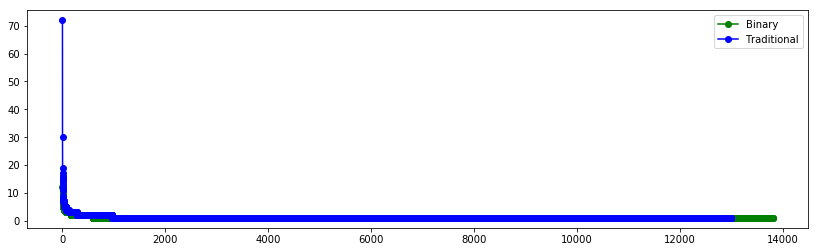

Pruebas-----
Cantidad de datos a llenar la tabla hash:  3668
Cantidad de memorias ocupadas hash1:  3591
Cantidad de memorias ocupadas hash2:  3406


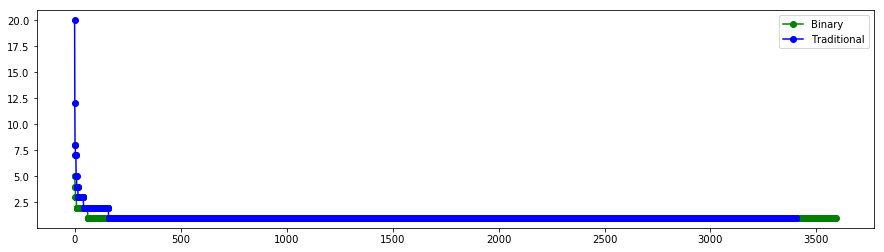

In [34]:
compare_cells_plot(BITS_S,train_hash_B, train_hash_, test_hash_B, test_hash_)